# Decision Trees

In this notebook I will implement decision tree models for both classification and regression.  I will use the breast cancer dataset from Article II to test the classification model, while the regression model will be tested using synthetic data.  Both implemented models will be compared to the decision trees available through scikit-learn.

In [1]:
## imports ##
from abc import ABC,abstractmethod
from scipy import stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer,make_regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_squared_error,mean_absolute_error,r2_score

In [28]:
#class to control tree node
class Node:
    #initializer
    def __init__(self):
        self.__Bs    = None
        self.__Bf    = None
        self.__left  = None
        self.__right = None
        self.leafv   = None

    #set the split,feature parameters for this node
    def set_params(self,Bs,Bf):
        self.__Bs = Bs
        self.__Bf = Bf
        
    #get the split,feature parameters for this node
    def get_params(self):
        return(self.__Bs,self.__Bf)    
        
    #set the left/right children nodes for this current node
    def set_children(self,left,right):
        self.__left  = left
        self.__right = right
        
    #get the left child node
    def get_left_node(self):
        return(self.__left)
    
    #get the right child node
    def get_right_node(self):
        return(self.__right)

In [29]:
#base class to encompass the decision tree algorithm
class DecisionTree(ABC):
    #initializer
    def __init__(self,max_depth=None,min_samples_split=2):
        self.tree              = None
        self.max_depth         = max_depth
        self.min_samples_split = min_samples_split
        
    #protected function to define the impurity
    @abstractmethod
    def _impurity(self,D):
         pass
        
    #protected function to compute the value at a leaf node
    @abstractmethod
    def _leaf_value(self,D):
         pass
        
    #private recursive function to grow the tree during training
    def __grow(self,node,D,level):       
        #are we in a leaf node? let's do some check...
        depth = (self.max_depth is None) or (self.max_depth >= (level+1))
        msamp = (self.min_samples_split <= D.shape[0])
        n_cls = np.unique(D[:,-1]).shape[0] != 1
        
        #not a leaf node
        if depth and msamp and n_cls:
        
            #initialize the function parameters
            ip_node = None
            feature = None
            split   = None
            left_D  = None
            right_D = None
            #iterrate through the possible feature/split combinations
            for f in range(D.shape[1]-1):
                for s in np.unique(D[:,f]):
                    #for the current (f,s) combination, split the dataset
                    D_l = D[D[:,f]<=s]
                    D_r = D[D[:,f]>s]
                    #ensure we have non-empty arrays
                    if D_l.size and D_r.size:
                        #calculate the impurity
                        ip  = (D_l.shape[0]/D.shape[0])*self._impurity(D_l) + (D_r.shape[0]/D.shape[0])*self._impurity(D_r)
                        #now update the impurity and choice of (f,s)
                        if (ip_node is None) or (ip < ip_node):
                            ip_node = ip
                            feature = f
                            split   = s
                            left_D  = D_l
                            right_D = D_r
            #set the current node's parameters
            node.set_params(split,feature)
            #declare child nodes
            left_node  = Node()
            right_node = Node()
            node.set_children(left_node,right_node)
            #investigate child nodes
            self.__grow(node.get_left_node(),left_D,level+1)
            self.__grow(node.get_right_node(),right_D,level+1)
                        
        #is a leaf node
        else:
            
            #set the node value & return
            node.leafv = self._leaf_value(D)
            return
     
    #private recursive function to traverse the (trained) tree
    def __traverse(self,node,Xrow):
        #check if we're in a leaf node?
        if node.leafv is None:
            #get parameters at the node
            (s,f) = node.get_params()
            #decide to go left or right?
            if (Xrow[f] <= s):
                return(self.__traverse(node.get_left_node(),Xrow))
            else:
                return(self.__traverse(node.get_right_node(),Xrow))
        else:
            #return the leaf value
            return(node.leafv)
    
    #train the tree model
    def train(self,Xin,Yin):
        #prepare the input data
        D = np.concatenate((Xin,Yin.reshape(-1,1)),axis=1)
        #set the root node of the tree
        self.tree = Node()
        #build the tree
        self.__grow(self.tree,D,1)
        
    #make predictions from the trained tree
    def predict(self,Xin):
        #iterrate through the rows of Xin
        p = []
        for r in range(Xin.shape[0]):
            p.append(self.__traverse(self.tree,Xin[r,:]))
        #return predictions
        return(np.array(p).flatten())

In [30]:
#Decision Tree Classifier
class DecisionTreeClassifier(DecisionTree):
    #initializer
    def __init__(self,max_depth=None,min_samples_split=2,loss='gini'):
        DecisionTree.__init__(self,max_depth,min_samples_split)
        self.loss = loss   
    
    #private function to define the gini impurity
    def __gini(self,D):
        #initialize the output
        G = 0
        #iterrate through the unique classes
        for c in np.unique(D[:,-1]):
            #compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            #compute term for the current c
            G += p*(1-p)
        #return gini impurity
        return(G)
    
    #private function to define the shannon entropy
    def __entropy(self,D):
        #initialize the output
        H = 0
        #iterrate through the unique classes
        for c in np.unique(D[:,-1]):
            #compute p for the current c
            p = D[D[:,-1]==c].shape[0]/D.shape[0]
            #compute term for the current c
            H -= p*np.log2(p)
        #return entropy
        return(H)
    
    #protected function to define the impurity
    def _impurity(self,D):
        #use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'gini':
            ip = self.__gini(D)
        elif self.loss == 'entropy':
            ip = self.__entropy(D)
        #return results
        return(ip)
    
    #protected function to compute the value at a leaf node
    def _leaf_value(self,D):
         return(stats.mode(D[:,-1])[0])

In [31]:
#Decision Tree Regressor
class DecisionTreeRegressor(DecisionTree):
    #initializer
    def __init__(self,max_depth=None,min_samples_split=2,loss='mse'):
        DecisionTree.__init__(self,max_depth,min_samples_split)
        self.loss = loss   
    
    #private function to define the mean squared error
    def __mse(self,D):
        #compute the mean target for the node
        y_m = np.mean(D[:,-1])
        #compute the mean squared error wrt the mean
        E = np.sum((D[:,-1] - y_m)**2)/D.shape[0]
        #return mse
        return(E)
    
    #private function to define the mean absolute error
    def __mae(self,D):
        #compute the mean target for the node
        y_m = np.mean(D[:,-1])
        #compute the mean absolute error wrt the mean
        E = np.sum(np.abs(D[:,-1] - y_m))/D.shape[0]
        #return mae
        return(E)
    
    #protected function to define the impurity
    def _impurity(self,D):
        #use the selected loss function to calculate the node impurity
        ip = None
        if self.loss == 'mse':
            ip = self.__mse(D)
        elif self.loss == 'mae':
            ip = self.__mae(D)
        #return results
        return(ip)
    
    #protected function to compute the value at a leaf node
    def _leaf_value(self,D):
         return(np.mean(D[:,-1]))

### Classification Model

Let's test out the classification model, using the breast cancer dataset we already examined in Article II

In [8]:
## load classification dataset ##
data = load_breast_cancer()
X    = data.data
y    = data.target

In [9]:
## what is the shape of the dataset? ##
print('shape of X: ',X.shape)
print('shape of y: ',y.shape)

shape of X:  (569, 30)
shape of y:  (569,)


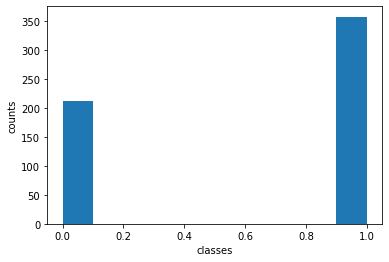

Percentage of y=0:  0.37258347978910367
Percentage of y=1:  0.6274165202108963


In [10]:
## is the dataset balanced? ##
plt.hist(y)
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

print('Percentage of y=0: ',y[y==0].shape[0]/y.shape[0])
print('Percentage of y=1: ',y[y==1].shape[0]/y.shape[0])

Clearly this dataset isn't balanced. We will need to account for this prior to training. I'll do this by selecting samples for training based upon their class values, ensuring I get an equal number for each class.  I want to use 60% of the data for training, and test the results on the remaining 40%.

In [11]:
## how many samples do I need per class for training? ##
nsampclass = int(np.round(y.shape[0]*0.6/2,decimals=0))
nsampclass

171

In [12]:
## do train/test split ##
#partition the training data by label
y0 = y[y==0]
y1 = y[y==1]
X0 = X[y==0]
X1 = X[y==1]
#select the elements to remove at random
idx0 = np.random.choice([i for i in range(y0.shape[0])],size=nsampclass,replace=False)
idx1 = np.random.choice([i for i in range(y1.shape[0])],size=nsampclass,replace=False)
#select samples for training
y_train0 = y0[idx0]
y_train1 = y1[idx1]
X_train0 = X0[idx0,:]
X_train1 = X1[idx1,:]
y_train  = np.concatenate((y_train0,y_train1))
X_train  = np.concatenate((X_train0,X_train1))
#use remainder for testing
y_test0 = np.delete(y0,idx0)
y_test1 = np.delete(y1,idx1)
X_test0 = np.delete(X0,idx0,axis=0)
X_test1 = np.delete(X1,idx1,axis=0)
y_test  = np.concatenate((y_test0,y_test1))
X_test  = np.concatenate((X_test0,X_test1))

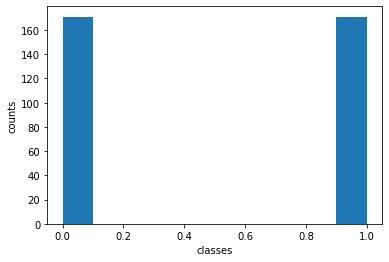

Percentage of y=0:  0.5
Percentage of y=1:  0.5


In [13]:
## is the training dataset balanced now? ##
plt.hist(y_train)
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

print('Percentage of y=0: ',y_train[y_train==0].shape[0]/y_train.shape[0])
print('Percentage of y=1: ',y_train[y_train==1].shape[0]/y_train.shape[0])

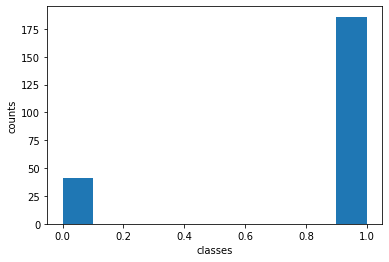

Percentage of y=0:  0.18061674008810572
Percentage of y=1:  0.8193832599118943


In [14]:
## what is the proportion of class 0/1 in the test set? ##
plt.hist(y_test)
plt.xlabel('classes')
plt.ylabel('counts')
plt.show()

print('Percentage of y=0: ',y_test[y_test==0].shape[0]/y_test.shape[0])
print('Percentage of y=1: ',y_test[y_test==1].shape[0]/y_test.shape[0])

Great, we can see that now there are an equal number of samples for both classes in the training dataset.  Since our feature space is relatively small (30), we will not consider dimension reduction as part of this analysis.

In [15]:
## declare the classifier and train the model ##
clf = DecisionTreeClassifier(max_depth=5,loss='gini')
clf.train(X_train,y_train)

In [16]:
## generate predictions ##
yp = clf.predict(X_test)

In [17]:
## evaluate model performance ##
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.90
precision: 0.97
recall: 0.90


Below let's compare with the results from the scikit-learn decision tree classifier:

In [18]:
## import the scikit-learn model ##
from sklearn.tree import DecisionTreeClassifier

In [19]:
## declare the classifier and train the model ##
clf = DecisionTreeClassifier(max_depth=5,criterion='gini')
clf.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=5)

In [20]:
## generate predictions ##
yp = clf.predict(X_test)

In [21]:
## evaluate model performance ##
print("accuracy: %.2f" % accuracy_score(y_test,yp))
print("precision: %.2f" % precision_score(y_test,yp))
print("recall: %.2f" % recall_score(y_test,yp))

accuracy: 0.90
precision: 0.98
recall: 0.90


Now let's tabulate the classifier results:

Model | Impurity Metric | Depth | Accuracy | Precision | Recall
-- | -- | -- | -- | -- | --
Custom | Gini | 5 | 0.93 | 0.98 | 0.93
Scikit | Gini | 5 | 0.93 | 0.98 | 0.93
Custom | Entropy | 5 | 0.93 | 0.97 | 0.95
Scikit | Entropy | 5 | 0.92 | 0.98 | 0.92
Custom | Gini | 10 | 0.90 | 0.98 | 0.90
Scikit | Gini | 10 | 0.93 | 0.98 | 0.93
Custom | Entropy | 10 | 0.91 | 0.98 | 0.91
Scikit | Entropy | 10 | 0.91 | 0.96 | 0.93

The results indicate the scikit-learn model and our custom built classifier are roughly compariable for all hyperparameter configurations attempted. Note the model shows signs of overfitting when the maximum tree depth is set to 10. Let's move on to test the performance of our regressor.

### Regression Model

We can check the performance of the regression tree model on a dummy dataset generated using the make_regression function from scikit-learn.  The dataset will consist of 8 features in total, 5 of which will be informative for the single target.  The standard deviation in the noise is set to 1, and a total of 1000 samples is generated.

In [37]:
## create a regression dataset ##
X,y = make_regression(n_samples=1000, n_features=8, n_informative=5, n_targets=1, noise=1, random_state=42)

In [38]:
## do train/test split ##
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
## declare the regressor and train the model ##
rgr = DecisionTreeRegressor(max_depth=5,loss='mae')
rgr.train(X_train,y_train)

In [40]:
## make predictions ##
yp = rgr.predict(X_test)

In [41]:
## evaluate model performance ##
print("rmse: %.2f" % np.sqrt(mean_squared_error(y_test,yp)))
print("mae: %.2f" % mean_absolute_error(y_test,yp))
print("r2: %.2f" % r2_score(y_test,yp))

rmse: 70.04
mae: 56.44
r2: 0.68


In [42]:
## import the scikit-learn model ##
from sklearn.tree import DecisionTreeRegressor

In [43]:
## declare the regressor and train the model ##
rgr = DecisionTreeRegressor(max_depth=5,criterion='mae')
rgr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mae', max_depth=5)

In [44]:
## make predictions ##
yp = rgr.predict(X_test)

In [45]:
## evaluate model performance ##
print("rmse: %.2f" % np.sqrt(mean_squared_error(y_test,yp)))
print("mae: %.2f" % mean_absolute_error(y_test,yp))
print("r2: %.2f" % r2_score(y_test,yp))

rmse: 63.68
mae: 49.35
r2: 0.74


Now let's tabulate the regressor results:

Model | Impurity Metric | Depth | RMSE | MAE' | R2
-- | -- | -- | -- | -- | --
Custom | MSE | 5 | 69.05 | 55.91 | 0.69
Scikit | MSE | 5 | 66.31 | 53.61 | 0.71
Custom | MAE | 5 | 70.04 | 56.44 | 0.68
Scikit | MAE | 5 | 63.68 | 49.35 | 0.74
Custom | MSE | 10 | 64.07 | 48.85 | 0.73
Scikit | MSE | 10 | 59.72 | 45.56 | 0.77
Custom | MAE | 10 | 55.53 | 41.88 | 0.80
Scikit | MAE | 10 | 56.09 | 42.19 | 0.80

Note that the mean absolute error is calculated differently for the impurity metric (MAE) versus evaluation metric (MAE'): 
* The impurity metric is computed with respect to the mean of the label values for any given node in the tree
* The evaluation metric is computed by taking the difference between predicted and actual label values for the entire test set

For 3/4 of the configurations tested, the scikit-learn regressor outperforms our custom built model. This is notable for the {impurity = MAE, depth = 5} and {impurity = MSE, depth = 10} configurations.  

The custom built model performs better for the {impurity = MAE, depth = 10} configuration, however. This is also the best performing model overall.

To improve performance of the custom built model, feel free to try replacing the mean (y_m) in the private impurity functions with the median. You can also try using deeper trees, since overfitting does not appear to be an issue here.